# Recognition of Yoga Postures

## Necessary libraries
We choose
[Pytorch](https://pytorch.org/)
as our framework for this project for its learning parh and It is Simple GPU installation.
And we are going to work with

In [1]:
import os
import shutil
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from utils import split_data
from fastai.vision.all import get_image_files,verify_images
import gradio as gr
from sklearn.metrics import confusion_matrix
import seaborn as sns


/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if CUDA is available to use GPU on the training 
train_on_gpu = tf.test.is_gpu_available()

if train_on_gpu:
    print('GPU con soporte CUDA disponible')
else:
    print('No se encontró GPU con soporte CUDA')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No se encontró GPU con soporte CUDA


In [3]:
images=get_image_files('../YOGA/dataset')
images
failed = verify_images(images)
failed

(#0) []

In [4]:
images=get_image_files('../YOGA/DATA')
images
failed = verify_images(images)
failed

(#0) []

In [5]:
images=get_image_files('../YOGA/dataset/test/')
images
failed = verify_images(images)
failed

(#0) []

In [6]:
# Define paths
downdog_SRC_DIR = "data/downdog"
goddess_SRC_DIR = "data/goddess"
plank_SRC_DIR = "data/plank"
tree_SRC_DIR = "data/tree"
warrior_SRC_DIR = "data/warrior"
TRAINING_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
TEST_DIR = "dataset/test"
#splitting the dataset
TRAINING_DDG_DIR = os.path.join(TRAINING_DIR, "downdog/")
VALIDATION_DDG_DIR = os.path.join(VALIDATION_DIR, "downdog/")
TEST_DDG_DIR = os.path.join(TEST_DIR, "downdog/")

TRAINING_GDS_DIR = os.path.join(TRAINING_DIR, "goddess/")
VALIDATION_GDS_DIR = os.path.join(VALIDATION_DIR, "goddess/")
TEST_GDS_DIR = os.path.join(TEST_DIR, "goddess/")

TRAINING_PLANK_DIR = os.path.join(TRAINING_DIR, "plank/")
VALIDATION_PLANK_DIR = os.path.join(VALIDATION_DIR, "plank/")
TEST_PLANK_DIR = os.path.join(TEST_DIR, "plank/")

TRAINING_TREE_DIR = os.path.join(TRAINING_DIR, "tree/")
VALIDATION_TREE_DIR = os.path.join(VALIDATION_DIR, "tree/")
TEST_TREE_DIR = os.path.join(TEST_DIR, "tree/")

TRAINING_WR_DIR = os.path.join(TRAINING_DIR, "warrior/")
VALIDATION_WR_DIR = os.path.join(VALIDATION_DIR, "warrior/")
TEST_WR_DIR = os.path.join(TEST_DIR, "warrior/")
# Define proportion of images used for training
train_size = 0.8
val_size = 0.1
test_size = 0.1

split_data(downdog_SRC_DIR,
           TRAINING_DDG_DIR,
           VALIDATION_DDG_DIR,
           TEST_DDG_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(goddess_SRC_DIR,
           TRAINING_GDS_DIR,
           VALIDATION_GDS_DIR,
           TEST_GDS_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(plank_SRC_DIR,
           TRAINING_PLANK_DIR,
           VALIDATION_PLANK_DIR,
           TEST_PLANK_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(tree_SRC_DIR,
           TRAINING_TREE_DIR,
           VALIDATION_TREE_DIR,
           TEST_TREE_DIR,
           split_ratio=(train_size,val_size, test_size))
split_data(warrior_SRC_DIR,
           TRAINING_WR_DIR,
           VALIDATION_WR_DIR,
           TEST_WR_DIR,
           split_ratio=(train_size,val_size, test_size))

Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.


In [7]:
print(f"Original Downdog directory has {len(os.listdir(downdog_SRC_DIR))} images")
print(f"Original Goddess directory has {len(os.listdir(goddess_SRC_DIR))} images")
print(f"Original Plank directory has {len(os.listdir(plank_SRC_DIR))} images")
print(f"Original Tree directory has {len(os.listdir(tree_SRC_DIR))} images")
print(f"Original Warrior directory has {len(os.listdir(warrior_SRC_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_DDG_DIR))} images of Dogdown for training")
print(f"There are {len(os.listdir(TRAINING_GDS_DIR))} images of Goddess for training")
print(f"There are {len(os.listdir(TRAINING_PLANK_DIR))} images of Plank for training")
print(f"There are {len(os.listdir(TRAINING_TREE_DIR))} images of Tree for training")
print(f"There are {len(os.listdir(TRAINING_WR_DIR))} images of Warrior for training\n")

print(f"There are {len(os.listdir(VALIDATION_DDG_DIR))} images of Dogdown for validation")           
print(f"There are {len(os.listdir(VALIDATION_GDS_DIR))} images of Goddess for validation")
print(f"There are {len(os.listdir(VALIDATION_PLANK_DIR))} images of Plank for validation")
print(f"There are {len(os.listdir(VALIDATION_TREE_DIR))} images of Tree for validation")
print(f"There are {len(os.listdir(VALIDATION_WR_DIR))} images of Warrior for validation\n")

print(f"There are {len(os.listdir(TEST_DDG_DIR))} images of Dogdown for test")
print(f"There are {len(os.listdir(TEST_GDS_DIR))} images of Goddess for test")
print(f"There are {len(os.listdir(TEST_PLANK_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_TREE_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_WR_DIR))} images of tree for test")

Original Downdog directory has 394 images
Original Goddess directory has 344 images
Original Plank directory has 447 images
Original Tree directory has 294 images
Original Warrior directory has 422 images

There are 315 images of Dogdown for training
There are 275 images of Goddess for training
There are 357 images of Plank for training
There are 235 images of Tree for training
There are 337 images of Warrior for training

There are 39 images of Dogdown for validation
There are 34 images of Goddess for validation
There are 44 images of Plank for validation
There are 29 images of Tree for validation
There are 42 images of Warrior for validation

There are 40 images of Dogdown for test
There are 35 images of Goddess for test
There are 46 images of Plank for test
There are 30 images of Plank for test
There are 43 images of tree for test


## Data


In [8]:
# Definir un generador de imágenes con transformaciones
batch_size = 8
width=250
height=250
data_generator = ImageDataGenerator(
    rescale=1.0/255,
    #rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Cargar imágenes del directorio y aplicar transformaciones
train_data = data_generator.flow_from_directory(
    TRAINING_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',  
)

validation_data = data_generator.flow_from_directory(
    VALIDATION_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',
)

test_data = data_generator.flow_from_directory(
    TEST_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',
)


Found 1517 images belonging to 5 classes.
Found 188 images belonging to 5 classes.
Found 194 images belonging to 5 classes.


In [9]:
for data, labels in train_data:
    print(labels)
    # Aquí puedes agregar más código para inspeccionar los datos y etiquetas
    break  # Detenemos el ciclo después de imprimir las etiquetas de un lote


[0. 4. 0. 1. 4. 2. 2. 2.]


In [10]:
train_data

Observemos una imagen 

['downdog', 'goddess', 'plank', 'tree', 'warrior']


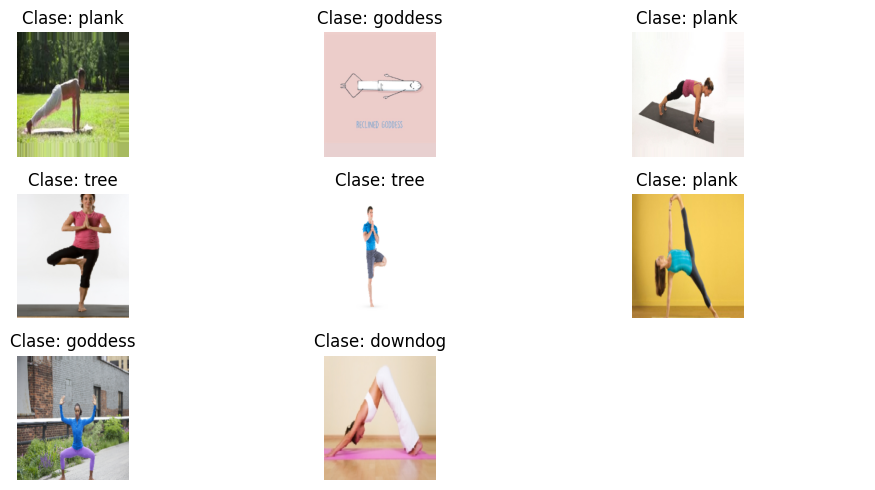

In [11]:

# Obtener un lote de imágenes y etiquetas del generador de datos
images, labels = next(train_data)

# Etiquetas de las clases (nombre de las carpetas)
class_labels = list(train_data.class_indices.keys())
print(class_labels)
# Configurar subplots
num_images = 8
num_cols = 3 # Número de columnas en la cuadrícula
num_rows = (num_images + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Iterar a través de las imágenes y subplots
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = images[i]
        label = class_labels[int(labels[i])]
        
        ax.imshow(image)
        ax.set_title(f"Clase: {label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [23]:
class Net(models.Model):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv2 = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')  # Cambio en el tamaño del filtro
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

        self.conv3 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))

        # Nueva capa convolucional
        self.conv4 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(64)
        self.bn_fc1 = layers.BatchNormalization()
        self.act_fc1 = layers.Activation('relu')
        self.dropout1 = layers.Dropout(0.3)  # Aumentar el dropout a 0.3

        self.fc2 = layers.Dense(5, activation='softmax')  

    def call(self, x):
        x = self.pool1(self.bn1(self.conv1(x)))
        x = self.pool2(self.bn2(self.conv2(x)))
        x = self.pool3(self.bn3(self.conv3(x)))
        x = self.pool4(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.bn_fc1(self.fc1(x))
        x = self.act_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [24]:
model = Net()


In [25]:
from tensorflow.keras.losses import categorical_crossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adam

criterion = SparseCategoricalCrossentropy()
#optimizer = Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

EPOCHS=15

In [26]:
print(len(train_data))

190


In [27]:
print(len(validation_data))

24


In [28]:
print(len(test_data))

25


In [29]:
model.compile(optimizer=optimizer, 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])


In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0, save_best_only=True)
callbacks=[ early_stopping, checkpoint ]

In [31]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=validation_data.n//validation_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size
STEP_SIZE_TRAIN

189

In [32]:
history =model.fit(train_data,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=validation_data,
        validation_steps=STEP_SIZE_VALID,
        epochs=EPOCHS,
        callbacks=callbacks
)

Epoch 1/15


2023-08-13 22:17:39.572610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


189/189 [==============================] - ETA: 0s - loss: 1.6125 - accuracy: 0.3632

2023-08-13 22:21:15.761587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 229s 1s/step - loss: 1.6125 - accuracy: 0.3632 - val_loss: 1.8534 - val_accuracy: 0.2935
Epoch 2/15
 77/189 [===========>..................] - ETA: 2:17 - loss: 1.3045 - accuracy: 0.4829

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - ETA: 0s - loss: 1.2506 - accuracy: 0.5030INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 234s 1s/step - loss: 1.2506 - accuracy: 0.5030 - val_loss: 1.1473 - val_accuracy: 0.5543
Epoch 3/15
 31/189 [===>..........................] - ETA: 3:10 - loss: 1.0766 - accuracy: 0.5927

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - ETA: 0s - loss: 1.0554 - accuracy: 0.6004INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 197s 1s/step - loss: 1.0554 - accuracy: 0.6004 - val_loss: 1.0349 - val_accuracy: 0.6033
Epoch 4/15
 13/189 [=>............................] - ETA: 2:12 - loss: 0.8446 - accuracy: 0.6827

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.6368INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 172s 909ms/step - loss: 0.9571 - accuracy: 0.6368 - val_loss: 0.7985 - val_accuracy: 0.7228
Epoch 5/15
 28/189 [===>..........................] - ETA: 2:17 - loss: 1.0448 - accuracy: 0.6116

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 234s 1s/step - loss: 0.8941 - accuracy: 0.6541 - val_loss: 1.0916 - val_accuracy: 0.5543
Epoch 6/15
189/189 [==============================] - 227s 1s/step - loss: 0.8395 - accuracy: 0.7064 - val_loss: 0.8323 - val_accuracy: 0.6848
Epoch 7/15
189/189 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6918INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 202s 1s/step - loss: 0.8461 - accuracy: 0.6918 - val_loss: 0.7318 - val_accuracy: 0.7609
Epoch 8/15
  1/189 [..............................] - ETA: 3:49 - loss: 0.9490 - accuracy: 0.7500

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 210s 1s/step - loss: 0.7743 - accuracy: 0.7290 - val_loss: 1.1567 - val_accuracy: 0.5380
Epoch 9/15
189/189 [==============================] - 254s 1s/step - loss: 0.7595 - accuracy: 0.7230 - val_loss: 0.7344 - val_accuracy: 0.7446
Epoch 10/15
189/189 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.7568INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 204s 1s/step - loss: 0.6886 - accuracy: 0.7568 - val_loss: 0.6355 - val_accuracy: 0.7717
Epoch 11/15
  1/189 [..............................] - ETA: 3:27 - loss: 0.7630 - accuracy: 0.8750

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7641INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 218s 1s/step - loss: 0.6651 - accuracy: 0.7641 - val_loss: 0.5919 - val_accuracy: 0.7880
Epoch 12/15
 37/189 [====>.........................] - ETA: 2:46 - loss: 0.5488 - accuracy: 0.8074

/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.7747INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


189/189 [==============================] - 252s 1s/step - loss: 0.6458 - accuracy: 0.7747 - val_loss: 0.5210 - val_accuracy: 0.8424
Epoch 13/15


/Users/johanjairgilcesreyes/.pyenv/versions/3.10.3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 [==============================] - 255s 1s/step - loss: 0.5987 - accuracy: 0.7853 - val_loss: 0.5348 - val_accuracy: 0.8207
Epoch 14/15
189/189 [==============================] - 270s 1s/step - loss: 0.6398 - accuracy: 0.7751 - val_loss: 0.6787 - val_accuracy: 0.7717
Epoch 15/15
189/189 [==============================] - 161s 849ms/step - loss: 0.5988 - accuracy: 0.7952 - val_loss: 0.8078 - val_accuracy: 0.7011


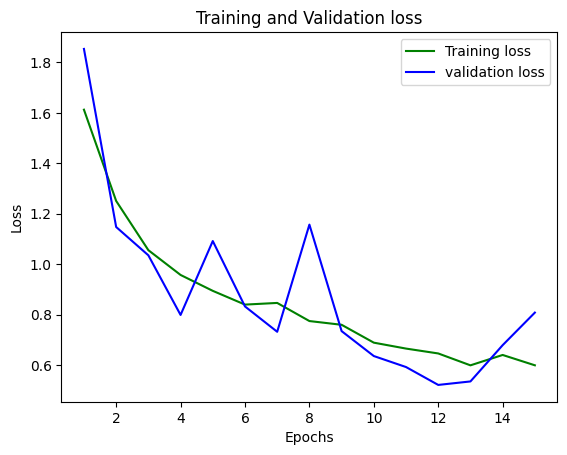

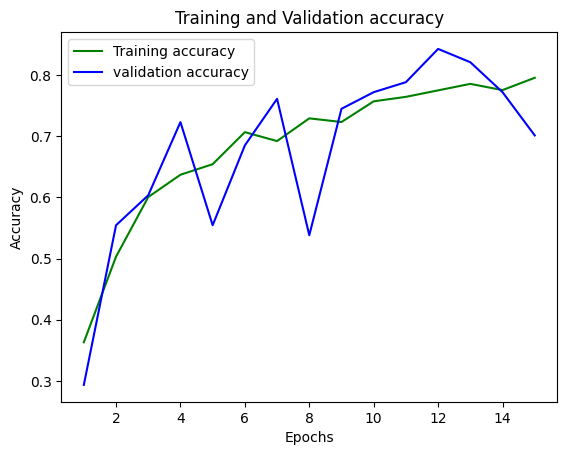

In [33]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [34]:
model.summary()

Model: "net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  896       
                                                                 
 batch_normalization_6 (Bat  multiple                  128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           multiple                  51264     
                                                                 
 batch_normalization_7 (Bat  multiple                  256       
 chNormalization)                                                
                                                             

In [35]:
model.save_weights('yoga_weights.h5')

In [36]:
#for gradio
def predict_image(img):
    # Redimensionar y preprocesar la imagen
    img = img.reshape(1, width, height, 3)
    img = img / 255.0

    # Hacer la predicción
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)

    # Obtener el nombre de la clase
    class_names = list(train_data.class_indices.keys())
    return class_names[predicted_class]


In [37]:


interface = gr.Interface(
    fn=predict_image, 
    inputs=gr.inputs.Image(shape=(width, height)), 
    outputs="text",
    live=True,
    capture_session=True
)
interface.launch()


/var/folders/x_/ll96cm_j5r34j0gcqbw987mw0000gn/T/ipykernel_64524/2586692711.py:3: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(shape=(width, height)),
/var/folders/x_/ll96cm_j5r34j0gcqbw987mw0000gn/T/ipykernel_64524/2586692711.py:3: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(shape=(width, height)),
/var/folders/x_/ll96cm_j5r34j0gcqbw987mw0000gn/T/ipykernel_64524/2586692711.py:1: GradioDeprecationWarning: `capture_session` parameter is deprecated, and it has no effect
  interface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### Resultados del modelo

2023-08-13 23:13:02.133376: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 10s 372ms/step


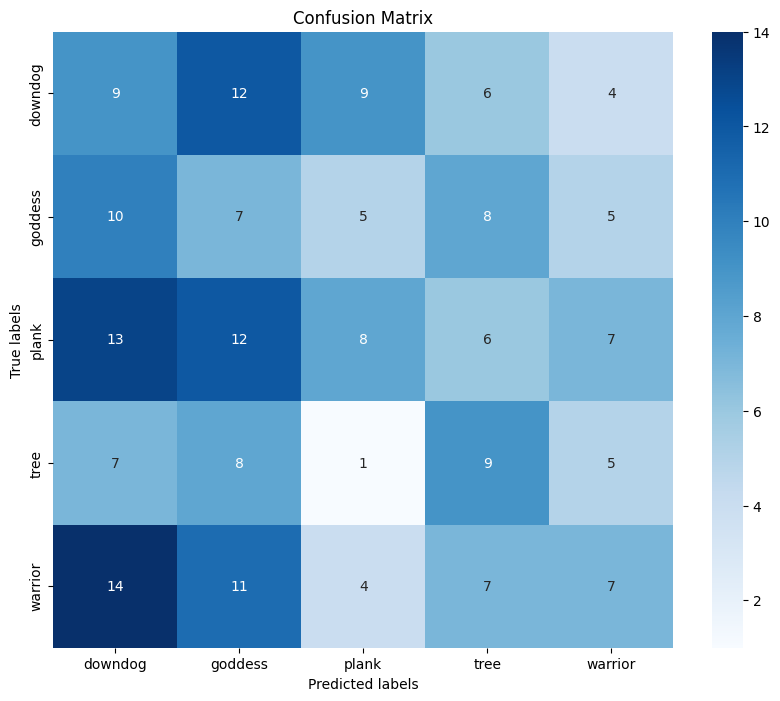

In [38]:
# Obtener las predicciones del modelo
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calcular la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
def display_activation_graph(model, image, layer_name):
    """
    Display the activations of a specific layer for a given image.
    
    Parameters:
    - model: Trained model.
    - image: Input image (should be preprocessed).
    - layer_name: Name of the layer whose activations you want to visualize.
    """
    
    # Create a sub-model that ends at the specified layer
    layer_output = getattr(model, layer_name).output
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=layer_output)
    
    # Get the activations for the image
    activations = intermediate_layer_model.predict(np.expand_dims(image, axis=0))
    
    # Number of features in the feature map
    num_features = activations.shape[-1]
    
    # Size of the grid
    size = int(np.sqrt(num_features))
    
    # Create a grid of subplots
    fig, axes = plt.subplots(size, size, figsize=(10, 10))
    
    for i in range(size):
        for j in range(size):
            if (i*size + j) < num_features:
                ax = axes[i, j]
                ax.imshow(activations[0, :, :, i*size + j], cmap='viridis')
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a preprocessed image called 'input_image'
# display_activation_graph(model, input_image, 'conv1')  # Display activations of the layer named 'conv1'


In [48]:
# Asegúrate de que el modelo ha sido llamado al menos una vez
dummy_input = np.random.random((1, width, height, 3))
_ = model(dummy_input)


In [49]:

from tensorflow.keras.preprocessing import image as keras_image

# 1. Cargar una imagen
img_path = '/Users/johanjairgilcesreyes/Desktop/ESPOL/IA/Proyecto/YOGA/DATA/tree/00000082.jpg'  
img = keras_image.load_img(img_path, target_size=(250, 224))

# 2. Preprocesar la imagen
img_array = keras_image.img_to_array(img)
img_array = img_array / 255.0  # Escalar los valores de píxeles al rango [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión para el batch

# 3. Usar la función display_activation_graph
# Asumiendo que tu modelo se llama 'model' y quieres visualizar las activaciones de la primera capa convolucional
display_activation_graph(model, img_array, 2)

TypeError: getattr(): attribute name must be string

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
